# Flight History - Data Aggregation and Exploration

#### This notebook will take the scrubbed data from the first notebook and combine it all into one dataframe, then we will do a little exploring

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Turns out there is no delay data available before 2003, meaning we can't do long-term analysis on delays

In [74]:
# create a list of years where we have delay data (begins in 2003)

# this dictionary looks weird because the loop to concatenate all the pickle files only worked with a dictionary
years = [2002,2003,2004,2005,2006,2007,2008]

# convert values in 'years' list from int to str
my_list = []
for i in years:
    i = str(i)
    my_list.append(i)
    
my_list

['2002', '2003', '2004', '2005', '2006', '2007', '2008']

In [75]:
dif_list = []

for i in my_list:
    try:
        load = 'datasets/flight_hist_pickle/cleaned_%s.pickle' %(i)
        temp = pd.read_pickle(load)
        dif_list = pd.DataFrame(dif_list.append(temp))
    except IOError:
        pass

In [76]:
# rename the list and turn it into a dataframe 
agg_flights = pd.DataFrame(dif_list)
agg_flights.head()

,lane_pairs,origin_airport,orig_state,dest_airport,dest_state,NAS,carrier,late_aircraft,security_delay,trip_count,weather,year
0,Abilene Regional-Dallas-Fort Worth International,Abilene Regional,TX,Dallas-Fort Worth International,TX,71,39,31,0,2211,10,2003
1,Abilene Regional-Easterwood,Abilene Regional,TX,Easterwood,TX,0,0,0,0,1,0,2003
2,Abilene Regional-George Bush Intercontinental,Abilene Regional,TX,George Bush Intercontinental,TX,3,19,8,0,317,7,2003
3,Adak-King Salmon,Adak,AK,King Salmon,AK,3,7,6,4,73,0,2003
4,Adak-Ted Stevens Anchorage International,Adak,AK,Ted Stevens Anchorage International,AK,0,0,0,0,1,0,2003


In [77]:
# normalize delays by calculating percentages of each delay
agg_flights['late_percent'] = agg_flights['late_aircraft'] / agg_flights['trip_count']
agg_flights['sec_percent'] = agg_flights['security_delay'] / agg_flights['trip_count']
agg_flights['weather_percent'] = agg_flights['weather'] / agg_flights['trip_count']
agg_flights['nas_percent'] = agg_flights['NAS'] / agg_flights['trip_count']
agg_flights['carrier_percent'] = agg_flights['carrier'] / agg_flights['trip_count']
agg_flights.head()

,lane_pairs,origin_airport,orig_state,dest_airport,dest_state,NAS,carrier,late_aircraft,security_delay,trip_count,weather,year,late_percent,sec_percent,weather_percent,nas_percent,carrier_percent
0,Abilene Regional-Dallas-Fort Worth International,Abilene Regional,TX,Dallas-Fort Worth International,TX,71,39,31,0,2211,10,2003,0.014021,0.000000,0.004523,0.032112,0.017639
1,Abilene Regional-Easterwood,Abilene Regional,TX,Easterwood,TX,0,0,0,0,1,0,2003,0.000000,0.000000,0.000000,0.000000,0.000000
2,Abilene Regional-George Bush Intercontinental,Abilene Regional,TX,George Bush Intercontinental,TX,3,19,8,0,317,7,2003,0.025237,0.000000,0.022082,0.009464,0.059937
3,Adak-King Salmon,Adak,AK,King Salmon,AK,3,7,6,4,73,0,2003,0.082192,0.054795,0.000000,0.041096,0.095890
4,Adak-Ted Stevens Anchorage International,Adak,AK,Ted Stevens Anchorage International,AK,0,0,0,0,1,0,2003,0.000000,0.000000,0.000000,0.000000,0.000000


### Now we can explore the dataset to understand what we have

### What state has the highest percentage of weather delays?

In [78]:
# i know this is an ugly and inefficient way to do it. more efficient method demonstrated for security delays
weather_df = pd.DataFrame(agg_flights['weather'].groupby(agg_flights['orig_state']).agg('sum'))
weather_df['trip_count'] = agg_flights['trip_count'].groupby(agg_flights['orig_state']).agg('sum')
weather_df['delay_percentage'] = weather_df['weather'] / weather_df['trip_count']
weather_df.reset_index(inplace = True)
weather_df.head()

,orig_state,weather,trip_count,delay_percentage
0,AK,1879,255076,0.007366
1,AL,4515,254190,0.017762
2,AR,2839,202117,0.014046
3,AZ,5176,1294836,0.003997
4,CA,19906,5006102,0.003976


### Which State has the most weather-related delays? The least?

In [79]:
weather_df[weather_df['orig_state'] == max(weather_df['orig_state'])]

,orig_state,weather,trip_count,delay_percentage
51,WY,833,49656,0.016775


In [80]:
weather_df[weather_df['orig_state'] == min(weather_df['orig_state'])]

,orig_state,weather,trip_count,delay_percentage
0,AK,1879,255076,0.007366


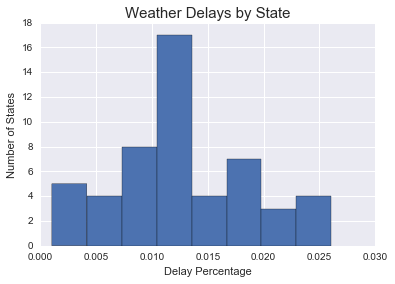

In [81]:
# how are the weather delays distributed across all 50 states?
weather_df['delay_percentage'].hist(bins = 8)
plt.title('Weather Delays by State', fontsize = 15)
plt.ylabel('Number of States')
plt.xlabel('Delay Percentage')

### Which airport has the most security-related delays?

In [82]:
sec_df = pd.DataFrame(agg_flights[['security_delay','trip_count']].groupby(agg_flights['orig_state']).agg('sum'))
sec_df.reset_index(inplace = True)

In [83]:
sec_df['sec_percentage'] = sec_df['security_delay'] / sec_df['trip_count']
sec_df[sec_df['sec_percentage'] == max(sec_df['sec_percentage'])]

,orig_state,security_delay,trip_count,sec_percentage
7,DE,4,765,0.005229


In [84]:
sec_df[sec_df['sec_percentage'] == min(sec_df['sec_percentage'])]

,orig_state,security_delay,trip_count,sec_percentage
15,KS,11,72987,0.000151


In [85]:
# just return the max value in one line
max(agg_flights['security_delay'].groupby(agg_flights['orig_state']).agg('sum') / agg_flights['trip_count'].groupby(agg_flights['orig_state']).agg('sum'))

0.0052287581699346402

## Graph distributions of different delay types by lane pair

In [86]:
# rename delay column headers so that they look better on the plot legends
agg_flights.rename(columns = {'late_percent':'Late Aircraft %',
                              'sec_percent':'Security Delay %',
                              'weather_percent':'Weather Delay %',
                              'nas_percent':'NAS Delay %',
                              'carrier_percent':'Carrier Delay %'}, inplace = True)

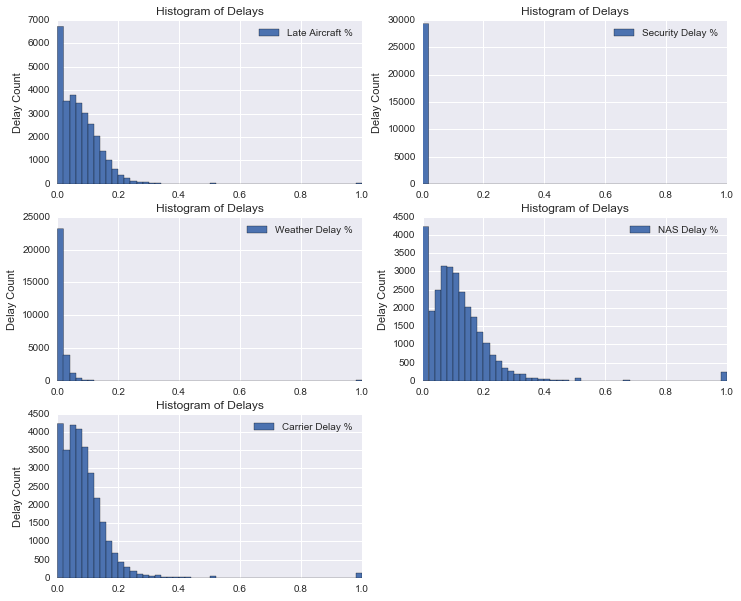

In [87]:
plt.subplots(figsize = (12,10))
for i, z in zip(agg_flights.columns[12:], range(len(agg_flights.columns[12:]))): # only use the last columns in the df
    z = z + 1 # iterator to produce individual plots for each loop
    plt.subplot(3,2,z)
    agg_flights[i].plot(kind = 'hist', bins = 50)
    plt.title('Histogram of Delays')
    plt.ylabel('Delay Count')
    plt.legend()